In [7]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import gdown

In [8]:
orders_file_id = '1hX2-KzS0nwyEuhi9dWy22PzRUczXVpn7'
orders_url = f'https://drive.google.com/uc?id={orders_file_id}'
orders_table = 'Orders Table.csv'

products_file_id = '1ATwj5A6yDHafhI7Az1DKgwX1UsDkuuAn'
products_url = f'https://drive.google.com/uc?id={products_file_id}'
products_table = 'Products Table.csv'

gdown.download(orders_url, orders_table, quiet=False)
gdown.download(products_url, products_table, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1hX2-KzS0nwyEuhi9dWy22PzRUczXVpn7
To: /Users/nltyh/Desktop/DSA3101-Project/inventory_management/Orders Table.csv
100%|██████████| 18.8M/18.8M [00:00<00:00, 19.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ATwj5A6yDHafhI7Az1DKgwX1UsDkuuAn
To: /Users/nltyh/Desktop/DSA3101-Project/inventory_management/Products Table.csv
100%|██████████| 2.08M/2.08M [00:00<00:00, 15.3MB/s]


'Products Table.csv'

In [9]:
orders = pd.read_csv('Orders Table.csv')
products = pd.read_csv('Products Table.csv')

df = orders.merge(products, on = 'ProductID', how = 'left')

## Price Elasticity of Each Product

### Merging datasets

In [10]:
np.random.seed(42)

sales = df.groupby('ProductID')['OrderID'].count().reset_index()
sales.rename(columns = {'OrderID': 'Total Sales'}, inplace = True)
sales = sales.merge(products, on = 'ProductID', how = 'left')

### Calculating Price Elasticity of Demand (PED)

In [11]:
mean_sales = np.mean(sales['Total Sales'])
mean_price = np.median(sales['Price'])

# generating synthetic data
sales['Previous Price'] = round(sales['Price'] * np.random.uniform(0.9, 1.1, len(sales)), 2)
sales['Previous Total Sales'] = round(mean_sales * (mean_price/sales['Previous Price']) + np.random.randint(0, 5, len(sales)))
sales['Previous Total Sales'] = sales['Previous Total Sales'].astype(int)

sales['Sales Percentage Change'] = 100 * (sales['Total Sales'] - sales['Previous Total Sales']) / sales['Previous Total Sales']
sales['Price Percentage Change'] = 100 * (sales['Price'] - sales['Previous Price']) / sales['Previous Price']

# calculating PED
sales['PED'] = round(abs(sales['Sales Percentage Change']/sales['Price Percentage Change']), 2)

# categorical column to group PED values
conditions = [
    (sales['PED'] == np.inf),
    (sales['PED'] == 0),
    (sales['PED'] > 1),
    (sales['PED'] == 1),
    (sales['PED'] < 1)
]

elasticity_categories = ['Perfectly Elastic', 'Perfectly Inelastic', 'Elastic', 'Unit Elastic', 'Inelastic']

sales['Price Elasticity'] = np.select(conditions, elasticity_categories, default = 'Unknown')

### Total Number of Products in Each Price Elasticity Category

Text(0, 0.5, 'Type of Price Elasticity')

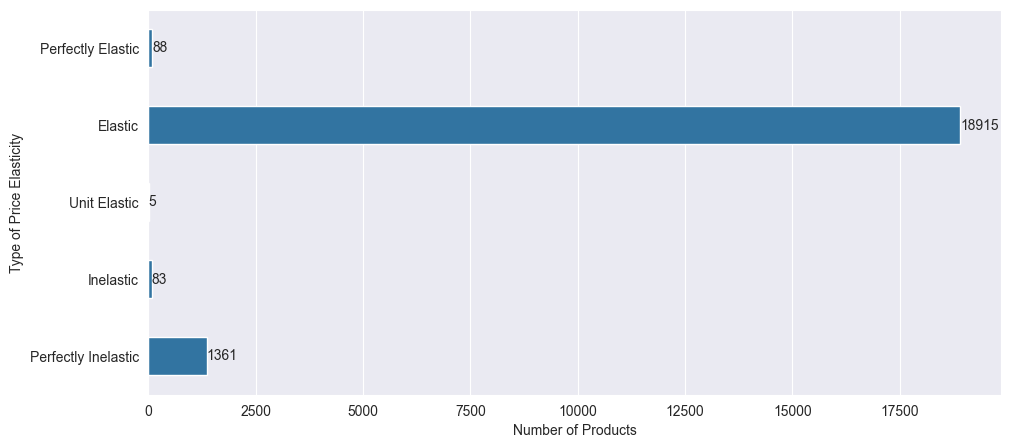

In [12]:
plt.figure(figsize = (11, 5))
sns.set_style('darkgrid')
order = ['Perfectly Elastic', 'Elastic', 'Unit Elastic', 'Inelastic', 'Perfectly Inelastic']
ax = sns.countplot(sales['Price Elasticity'], order = order, width = 0.5)
ax.bar_label(ax.containers[0])

plt.xlabel('Number of Products')
plt.ylabel('Type of Price Elasticity')

### Distribution of Elastic Products

/var/folders/ds/x32_jrs12jv6kcrbpc456sh80000gn/T/ipykernel_32775/550863334.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elastic_products['log_PED'] = np.log(elastic_products['PED'])


Text(0.5, 1.0, 'Distribution of PED for Elastic Products')

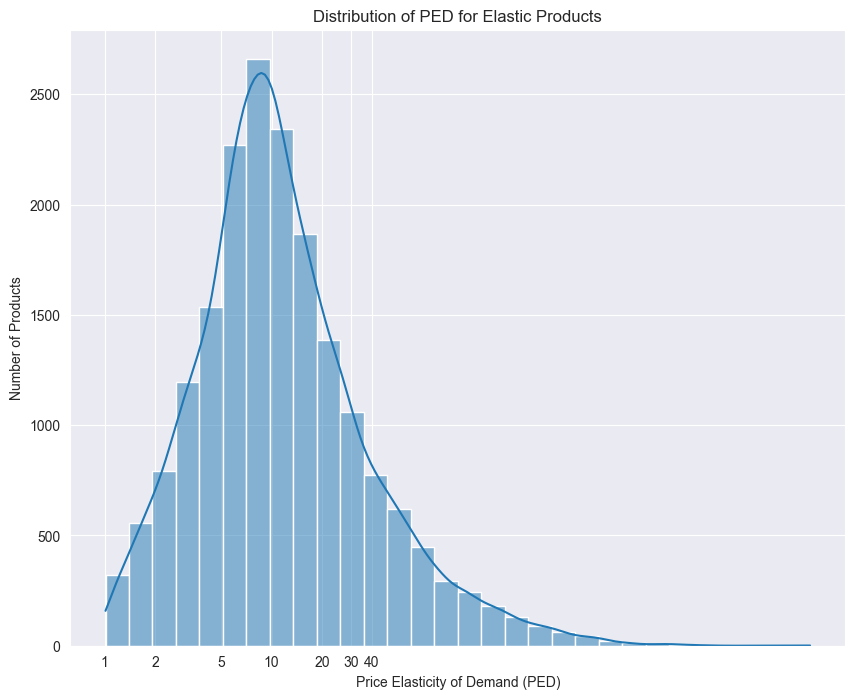

In [13]:
elastic_products = sales[sales['Price Elasticity'] == 'Elastic']
elastic_products['log_PED'] = np.log(elastic_products['PED'])

plt.figure(figsize=(10, 8))
sns.set_style('darkgrid')
sns.histplot(elastic_products['log_PED'], kde = True, bins = 30)

actual_PED_values = [1, 2, 5, 10, 20, 30, 40]
log_PED_values = np.log(actual_PED_values)  

plt.xticks(log_PED_values, actual_PED_values)
plt.xlabel('Price Elasticity of Demand (PED)')
plt.ylabel('Number of Products')
plt.title('Distribution of PED for Elastic Products')

Due to the right-skewed nature of the distribution of PED in our data, we chose to visualize the logarithm of the PED instead. The labels on the x-axis display the actual PED values, but the scale is in logarithmic form.

We can see that most elastic products are concentrated in the range of values from 5 to 20.
This concentration indicates that for these products, a 1% increase in price results in a 5% to 20% decrease in quantity demanded, reflecting highly elastic demand. Such a high sensitivity suggests that consumers are very responsive to price changes, possibly due to the availability of substitutes or the non-essential nature of these goods.

### Distribution of Inelastic Products

Text(0.5, 1.0, 'Distribution of PED for Inelastic Products')

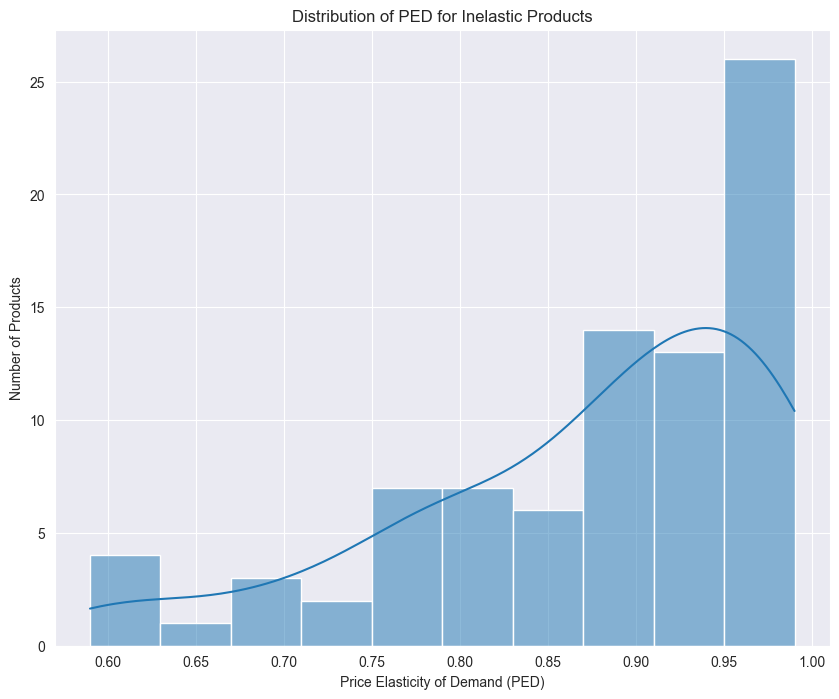

In [14]:
inelastic_products = sales[sales['Price Elasticity'] == 'Inelastic']

plt.figure(figsize=(10, 8))
sns.set_style('darkgrid')
sns.histplot(inelastic_products['PED'], kde = True, bins = 10)

plt.xlabel('Price Elasticity of Demand (PED)')
plt.ylabel('Number of Products')
plt.title('Distribution of PED for Inelastic Products')

For inelastic products, most products are in the range of 0.85 to 1, indicating that while demand is relatively unresponsive to price changes, it is close to being unit elastic. This means that when the price of such products increases, the quantity demanded decreases only slightly. For example, if the price rises by 1%, the quantity demanded might decrease by around 0.85% to 1%, reflecting a modest reduction in demand.

Consumers are somewhat responsive to price changes but still continue purchasing at similar rates. Businesses can typically increase prices without significantly reducing demand, but because the PED is close to 1, they should do so cautiously to avoid diminishing returns.

## Price Elasticity for Categories

Text(0.5, 1.0, 'Mean PED by Category')

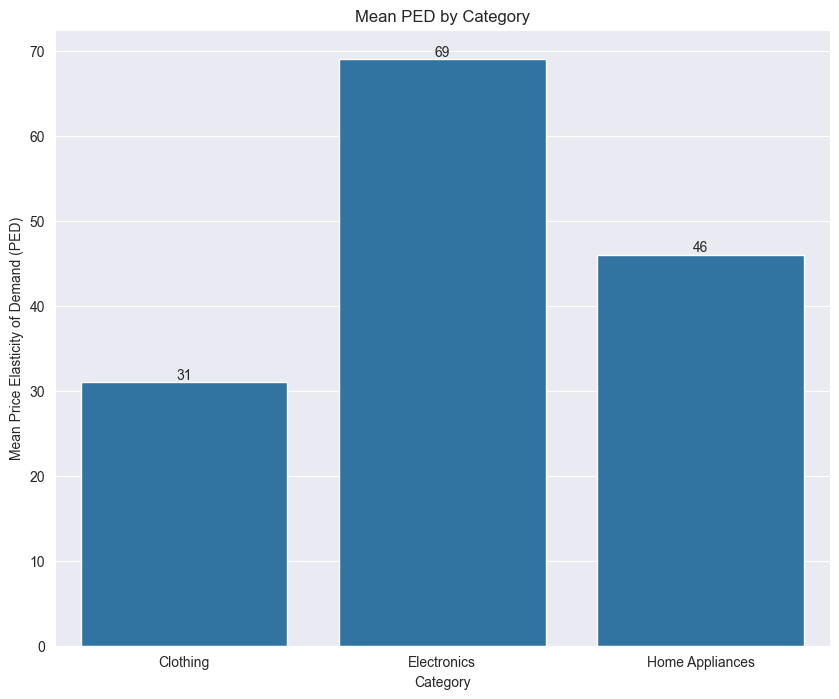

In [15]:
sales_filtered = sales[~sales['Price Elasticity'].isin(['Perfectly Elastic', 'Perfectly Inelastic', 'Unit Elastic'])]
categories_mean_PED = round(sales_filtered.groupby('Category')['PED'].mean())

plt.figure(figsize=(10, 8))
sns.set_style('darkgrid')
ax = sns.barplot(x = categories_mean_PED.index, y = categories_mean_PED.values)
ax.bar_label(ax.containers[0])
plt.xlabel('Category')
plt.ylabel('Mean Price Elasticity of Demand (PED)')
plt.title('Mean PED by Category')

Electronics has the most elasticity, followed by Home Appliances and then Clothing.

This could be because Electronics are discretionary, frequently updated, and have many substitutes, making consumers highly price-sensitive. Home appliances are moderately elastic due to longer replacement cycles and fewer substitutes but are still essential. Clothing has the lowest elasticity since it’s a necessity, widely available at varying price points, and influenced by seasonal and trend-driven demand, making consumers less responsive to price changes.

### Distribution of PED across Product Categories

In [16]:
electronics = sales_filtered[sales_filtered['Category'] == 'Electronics']
clothing = sales_filtered[sales_filtered['Category'] == 'Clothing']
home = sales_filtered[sales_filtered['Category'] == 'Home Appliances']

electronic_elastic = electronics[electronics['Price Elasticity'] == 'Elastic']
clothing_elastic = clothing[clothing['Price Elasticity'] == 'Elastic']
home_elastic = home[home['Price Elasticity'] == 'Elastic']

electronic_elastic['log_PED'] = np.log(electronic_elastic['PED'])
clothing_elastic['log_PED'] = np.log(clothing_elastic['PED'])
home_elastic['log_PED'] = np.log(home_elastic['PED'])

electronic_inelastic = electronics[electronics['Price Elasticity'] == 'Inelastic']
clothing_inelastic = clothing[clothing['Price Elasticity'] == 'Inelastic']
home_inelastic = home[home['Price Elasticity'] == 'Inelastic']

/var/folders/ds/x32_jrs12jv6kcrbpc456sh80000gn/T/ipykernel_32775/244393847.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  electronic_elastic['log_PED'] = np.log(electronic_elastic['PED'])
/var/folders/ds/x32_jrs12jv6kcrbpc456sh80000gn/T/ipykernel_32775/244393847.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clothing_elastic['log_PED'] = np.log(clothing_elastic['PED'])
/var/folders/ds/x32_jrs12jv6kcrbpc456sh80000gn/T/ipykernel_32775/244393847.py:11: SettingWithCopyWarning: 
A value is trying to b

Text(0.5, 1.0, 'Distribution of (Elastic) PED across Categories')

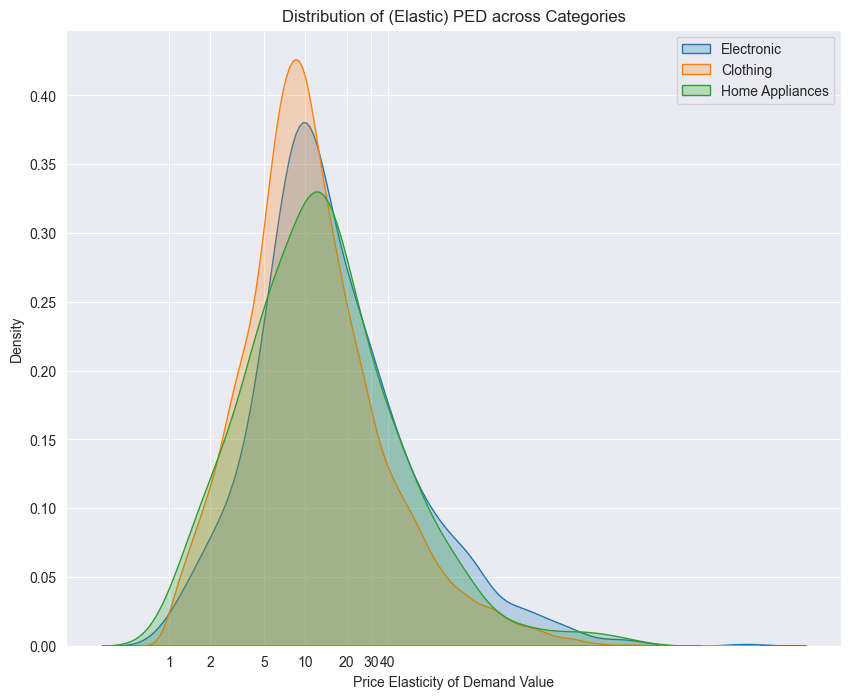

In [17]:
plt.figure(figsize=(10, 8))
sns.set_style('darkgrid')
sns.kdeplot(electronic_elastic['log_PED'], fill = True, label = 'Electronic')
sns.kdeplot(clothing_elastic['log_PED'], fill = True, label = 'Clothing')
sns.kdeplot(home_elastic['log_PED'], fill = True, label = 'Home Appliances')

actual_PED_values = [1, 2, 5, 10, 20, 30, 40]
log_PED_values = np.log(actual_PED_values)  

plt.legend()
plt.xticks(log_PED_values, actual_PED_values)
plt.xlabel('Price Elasticity of Demand Value')
plt.title('Distribution of (Elastic) PED across Categories')

We can see that the distribution of elastic PED values are actually quite similar across categories. 

In other words, highly elastic products—whether electronics, home appliances, or clothing—tend to exhibit comparable levels of consumer price sensitivity. This similarity suggests that factors influencing price elasticity, such as the availability of substitutes, consumer discretionary spending, and the non-essential nature of the products, may be consistent across categories once a product is deemed elastic.

This insight is useful for pricing strategy, as it implies that for products with high elasticity, similar discounting or promotional tactics may yield comparable results across different product categories.

/var/folders/ds/x32_jrs12jv6kcrbpc456sh80000gn/T/ipykernel_32775/496336422.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(home_inelastic['PED'], fill = True, label = 'Home Appliances') # only got one product that's why not showing up


Text(0.5, 1.0, 'Distribution of (Inelastic) PED across Categories')

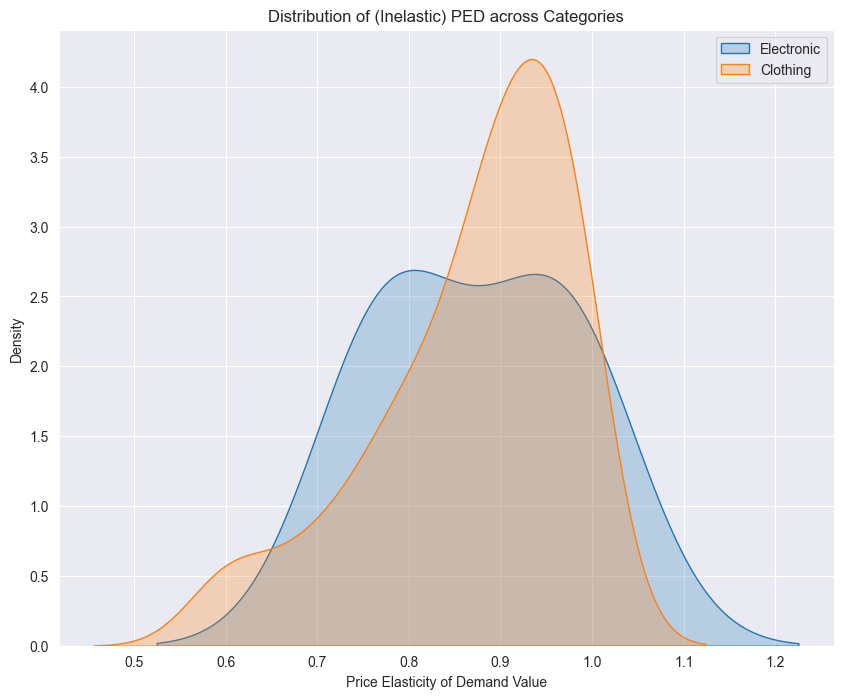

In [18]:
plt.figure(figsize=(10, 8))
sns.set_style('darkgrid')
sns.kdeplot(electronic_inelastic['PED'], fill = True, label = 'Electronic')
sns.kdeplot(clothing_inelastic['PED'], fill = True, label = 'Clothing')
sns.kdeplot(home_inelastic['PED'], fill = True, label = 'Home Appliances') # only got one product that's why not showing up

plt.legend()
plt.xlabel('Price Elasticity of Demand Value')
plt.title('Distribution of (Inelastic) PED across Categories')

Home Appliances only has one inelastic product, hence it is not shown in the density plot above.

For inelastic products, the PED values for Electronics are more uniformly distributed as compared to Clothing. The uniformity in Electronics may reflect consistent consumer reliance on certain products despite price changes, likely due to perceived necessity or lack of substitutes within this category. In contrast, the varied PED distribution in Clothing indicates that some items are essential with stable demand, while others are more discretionary, making demand less uniformly inelastic across products.